In [ ]:
%pip install -U nltk

In [1]:
import sys
sys.path.insert(0,'/Users/simkinp/Documents/DS-autumn-2019/centrica-frontend/the-loom-centrica')

In [2]:
from utils import GCP
import pandas as pd
import os
from google.cloud import storage

class GCP():
    def __init__(self,bucket_name = r"raw-data-staging",creds_location = 'creds\creds.json'):
        self.bucket_name = bucket_name
        os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'creds/creds.json'
        self.call_gcp_client()

        
    def call_gcp_client(self):
        self.storage_client = storage.Client()
        
        # load the data from GC storage
        self.bucket = self.storage_client.bucket(self.bucket_name)
        
    def collect_blobs(self):
        blobs = self.bucket.list_blobs()
        # Collate data and remove unnecessary dependencies
        temp = []
        for file in blobs:
            file_path = r"gs://" + self.bucket_name + '/' + file.name
            if file.name.startswith("netbase"):
                if file.name.endswith("csv"):
                    temp.append([pd.read_csv(file_path, encoding='utf-8'),
                                 file.size,
                                 file.name,
                                 file.time_created])
                elif file.name.startswith("netbase") and file.name.endswith("xlsx"):
                    temp.append([pd.read_excel(file_path, encoding='utf-8'),
                                 file.size,
                                 file.name,
                                 file.time_created])
        return temp

In [3]:
gcp = GCP()

In [ ]:
data = pd.read_gbq("SELECT * FROM analysed.merged_data WHERE company == 'BG_UK'")

# Clustering

In [6]:
data = pd.read_gbq("SELECT * FROM analysed.merged_data WHERE company == 'BG_UK'")

Downloading: 100%|██████████| 21003/21003 [00:03<00:00, 6363.03rows/s]


In [10]:
data['Source']

KeyError: 'Source'

Downloading: 100%|██████████| 259/259 [00:00<00:00, 910.31rows/s]


Tokenised 78 documents using a vocabulary of 7 tokens.
Created embeddings for 78 documents


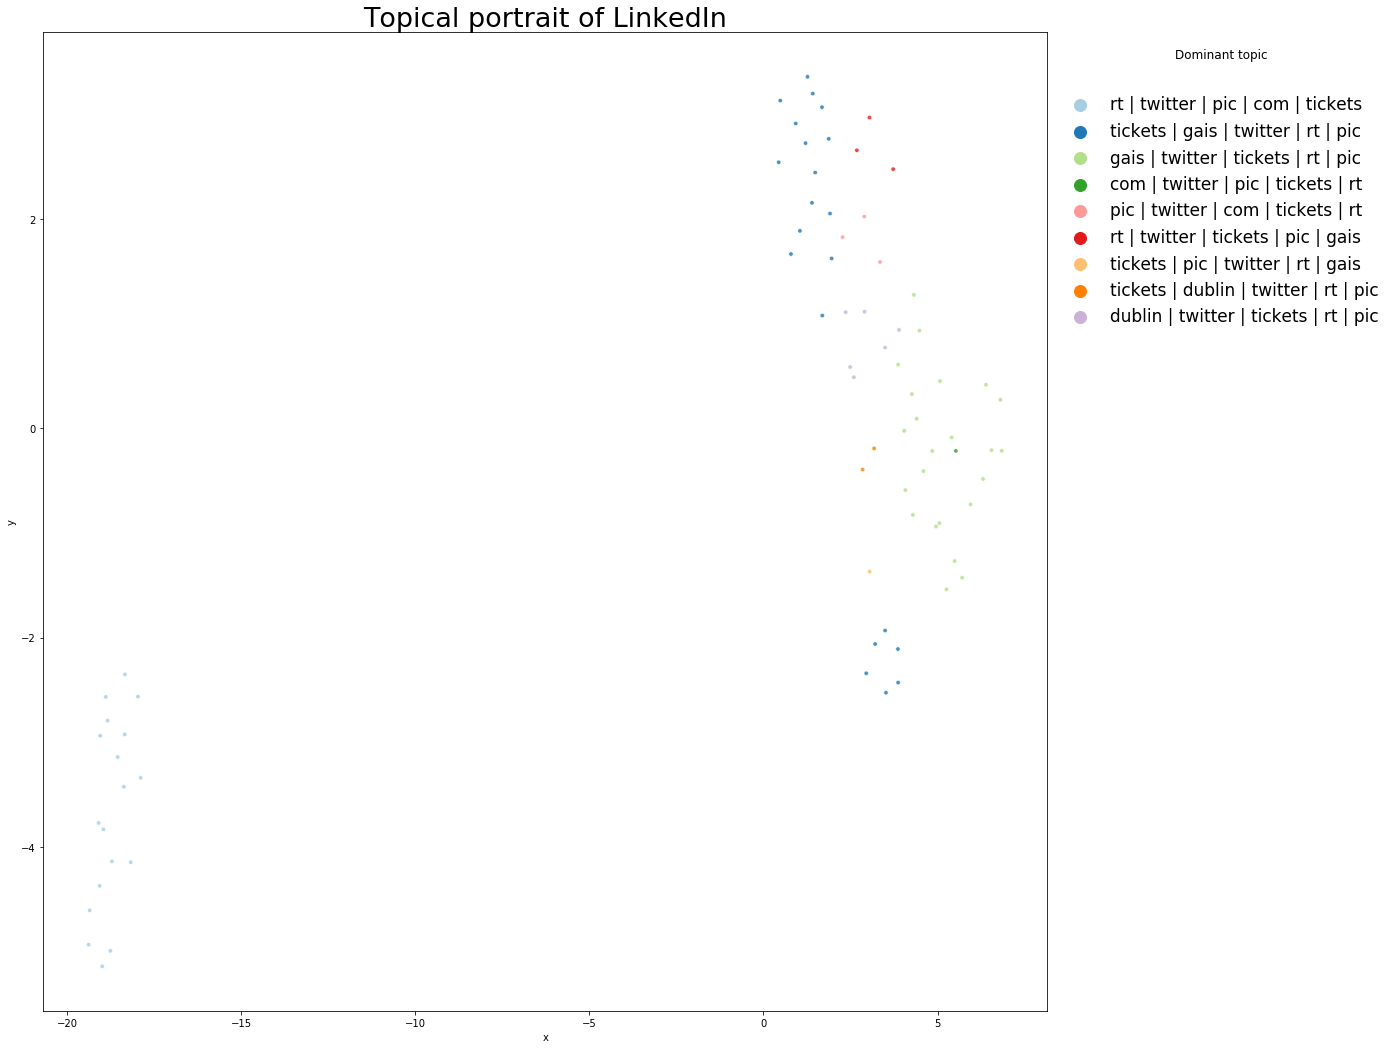

In [5]:
# sup press warnings
import tqdm
from pathlib import Path
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np

import requests
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import string

from utils import clustering_utils
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
from nltk.corpus import stopwords
from umap import UMAP
import hdbscan
import re
import glob

import tensorflow.compat.v1 as tf
import tensorflow_hub as hub

# tensorflow V2 issues prevent loading modules - so we just disable 
tf.disable_v2_behavior()

# load universal-sentence-embeddings
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3"
embed = hub.Module(module_url)

# render plots within the notebook
%matplotlib inline

# params
text_col = 'text'
title_col = 'title'
fn = 'BordGais_Ireland'

# stopwords
STOPWORDS = set(stopwords.words('english'))

# read data & define corpus/mapping 
data = pd.read_gbq("SELECT * FROM analysed.merged_data WHERE company == '{}' LIMIT 3000".format(fn))
data.drop_duplicates(subset='text')
data = data.sample(frac=0.3)
data = data[data[text_col].isnull() == False]
corpus = data[text_col].tolist()

# universal sentence embeddings
with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    corpus_embeddings = session.run(embed(data[text_col].tolist()))
    
    
# basic tf-idf feature extraction
X_tfidf, tfidf = clustering_utils.tokenize(corpus,    # the corpus 
                          min_df=20,                  # only consider words which appear in at least 10 docs
                          max_df=0.5,                 # only consider words which appear in at most 50% of the docs
                          lowercase=True,             # convert everything to lowercase
                          token_pattern='[a-z]{2,}',  # what's a token (2 or more letters)
                          stop_words=STOPWORDS,       # which words are to be excluded
                          max_features=15000          # keep the top 10,000 tokens (based on tfidf scores)
                          )

# topic model initialise 
model = NMF(n_components=11, random_state=0)
X_nmf = model.fit_transform(X_tfidf)
dominant_topic = X_nmf.argsort(axis=1)[:, -1]
topics = clustering_utils.extract_topics(model, tfidf, n=5)
list_tops = [x for x in list(clustering_utils.extract_topics(model, tfidf, n=5).values())]

print("Created embeddings for {} documents".format(len(data)))

# horizontally stack both sets of features
X = pd.DataFrame(np.hstack((X_nmf, corpus_embeddings)))

# dimensionality reduction and projection
proj = UMAP(n_components=2, n_neighbors=20, min_dist=0.5, random_state=0)
X_proj = proj.fit_transform(X.values)

# reformat
df_proj = (pd.DataFrame(X_proj, columns=['x', 'y'])
               .assign(topic_num = dominant_topic)
          )
df_proj = df_proj.assign(topic=df_proj.topic_num.map(topics))
df_proj = pd.concat((df_proj, pd.DataFrame(X_nmf)), axis='columns')
df_proj['text_reference'] = data[title_col]
df_proj['comment'] = data[text_col]
df_proj = df_proj[['x', 'y', 'topic_num', 'topic', 'text_reference', 'comment']]

# plot & write to csv
ax = clustering_utils.plot_embedding(df_proj)
df_proj.columns = ['X', 'Y', 'labels', 'topic',  'text_reference', 'comment']
df_proj.to_csv('/Users/simkinp/Documents/DS-autumn-2019/centrica-frontend/centrica/src/assets/BordGais/data_cluster.csv')


In [ ]:
data['text']

In [ ]:
df_proj